In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import pandas as pd
from model.utils import load_predictions, ASSETS, RiskLabel, PLOT

Done! Loaded utils.py


In [2]:
y_true, y_pred = load_predictions(f'{ASSETS}y_true_pred.pkl')

report_dict = classification_report(y_true, y_pred, output_dict=True)

ordered_label_names = RiskLabel.get_names()[0:7]

label_names = [str(i) for i in range(len(ordered_label_names))]
df_report = pd.DataFrame(report_dict).transpose().loc[label_names]
df_report.index = ordered_label_names

df_report.head(10)

Predictions loaded from ../../assets/y_true_pred.pkl


,precision,recall,f1-score,support
legal,1.000000,0.854167,0.921348,48.0
account,0.938492,0.989540,0.963340,478.0
payment,1.000000,0.727273,0.842105,44.0
technical,0.993506,0.962264,0.977636,318.0
delivery,0.944444,0.809524,0.871795,21.0
service,0.961686,0.972868,0.967245,258.0
pricing,0.968504,0.976190,0.972332,378.0


<Figure size 400x300 with 0 Axes>

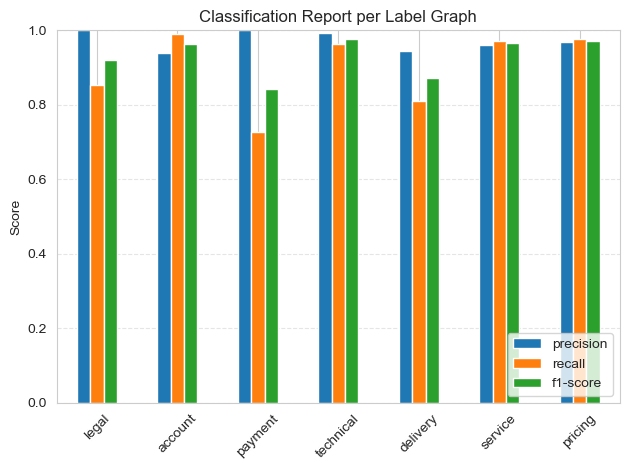

In [3]:
plt.figure(figsize=(4, 3))
df_report[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title('Classification Report per Label Graph')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(f'{ASSETS}Classification Report per Label Graph')
plt.show()
plt.close()

In [4]:
df_text = pd.read_csv(f'{ASSETS}suspect_level_1.csv').dropna()
df_text.head()

,tweet_id,text
0,8,@sprintcare is the worst customer service
1,36,somebody from @VerizonSupport please help meee...
2,49,@115722 tried to pay a bill for 60 days. No se...
3,59,@115722 is the worst ISP I’ve ever had
4,161,"@ChipotleTweets Tried, didn't work. How rude :/"


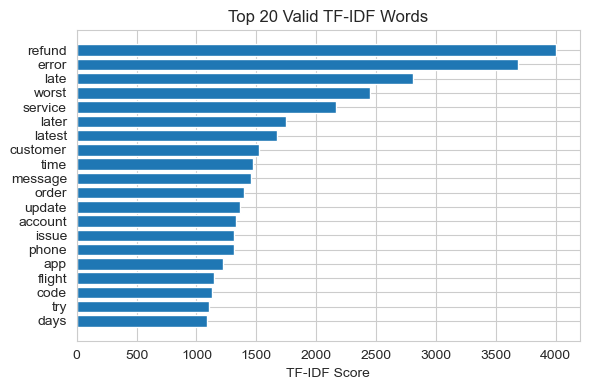

In [6]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd

custom_stop_words = [
    'rt', 'https', 'co', 'my', 'i',
    'the', 'to', 'and', 'is', 'for',
    'you', 'but', 'we', 'that', 'this',
    'amazonhelp', 'applesupport',
    'hi', 'thanks', 'sorry', 'just', 've',
    'pls', 'please', 'im', 'ive', 'youre',
    'dm', 'know', 'help', 'getting', 'like',
    'amp', 'll', 'let'
]
combined_stopwords = list(ENGLISH_STOP_WORDS.union(custom_stop_words))

top_n=20

vectorizer = TfidfVectorizer(stop_words=combined_stopwords)
X = vectorizer.fit_transform(df_text['text'])

# 得到所有词与其TF-IDF总值
tfidf_scores = X.sum(axis=0).A1
terms = vectorizer.get_feature_names_out()
tfidf_df = pd.DataFrame({'term': terms, 'score': tfidf_scores})
tfidf_df = tfidf_df.sort_values(by='score', ascending=False).head(top_n)

plt.figure(figsize=(6, 4))
plt.barh(tfidf_df['term'][::-1], tfidf_df['score'][::-1])  # 倒序以高的在上
plt.xlabel('TF-IDF Score')
plt.title(f'Top {top_n} Valid TF-IDF Words')
plt.tight_layout()
plt.savefig(f'{ASSETS}tfidf_words.png')
plt.show()
plt.close()

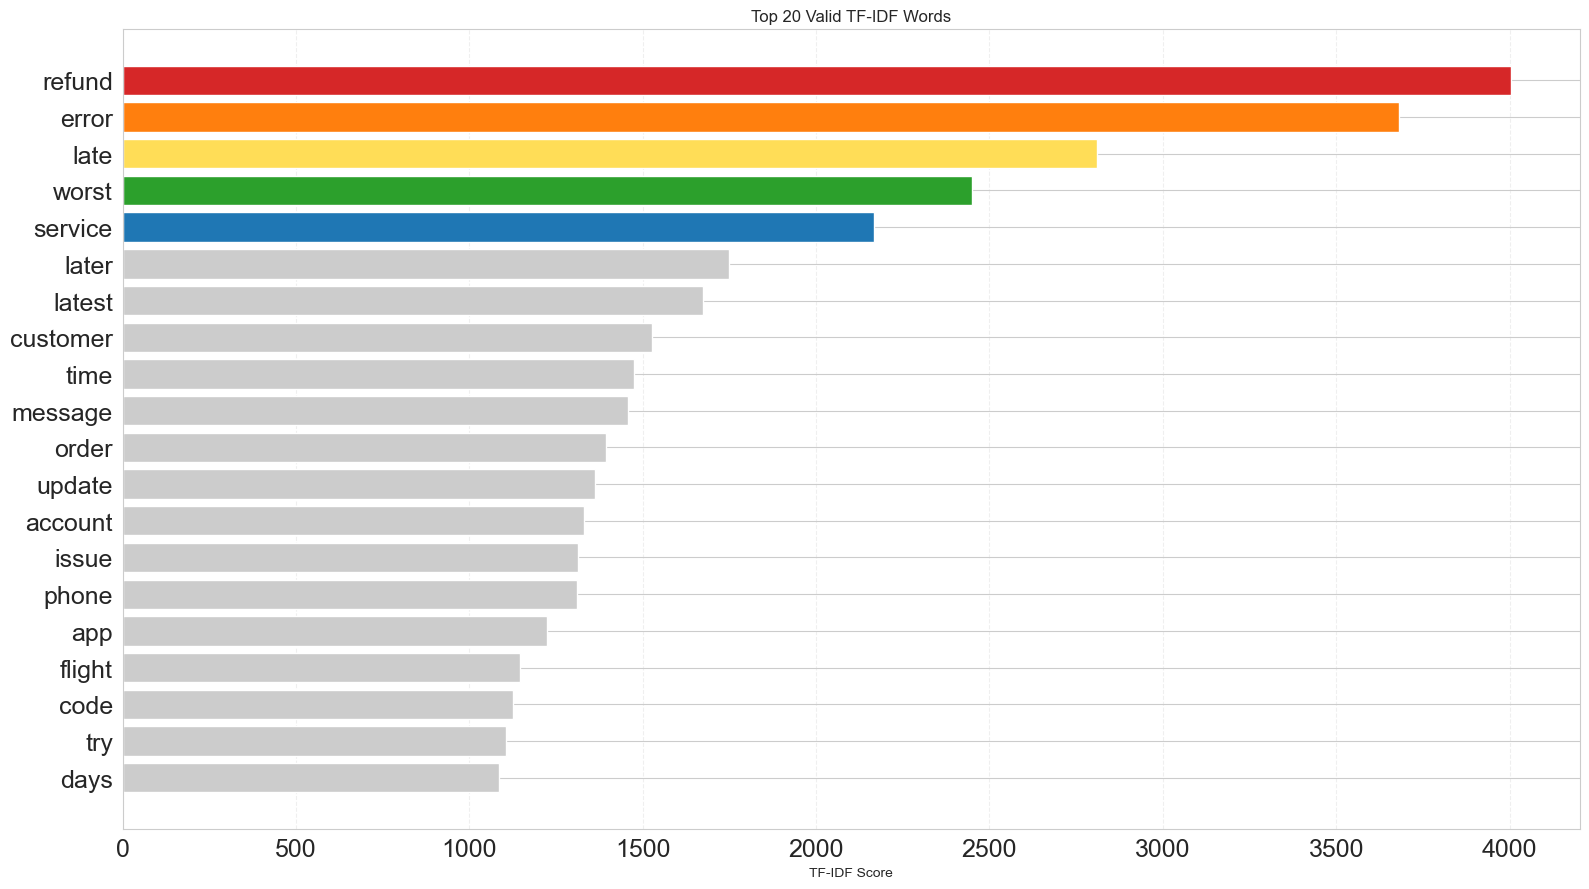

In [7]:
highlight_colors = ['#d62728', '#ff7f0e', '#ffdd57', '#2ca02c', '#1f77b4']  
num_highlight = 5
colors = highlight_colors + ['#cccccc'] * (len(tfidf_df) - num_highlight)

# 倒序用于从上到下排列（TF-IDF 值从高到低）
terms = tfidf_df['term'][::-1]
scores = tfidf_df['score'][::-1]
bar_colors = colors[::-1]  

plt.figure(figsize=(16, 9))
plt.barh(terms, scores, color=bar_colors)
plt.xlabel('TF-IDF Score')
plt.title(f'Top {top_n} Valid TF-IDF Words')
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.savefig(f'{PLOT}tfidf_words_colored.png')
plt.show()
plt.close()

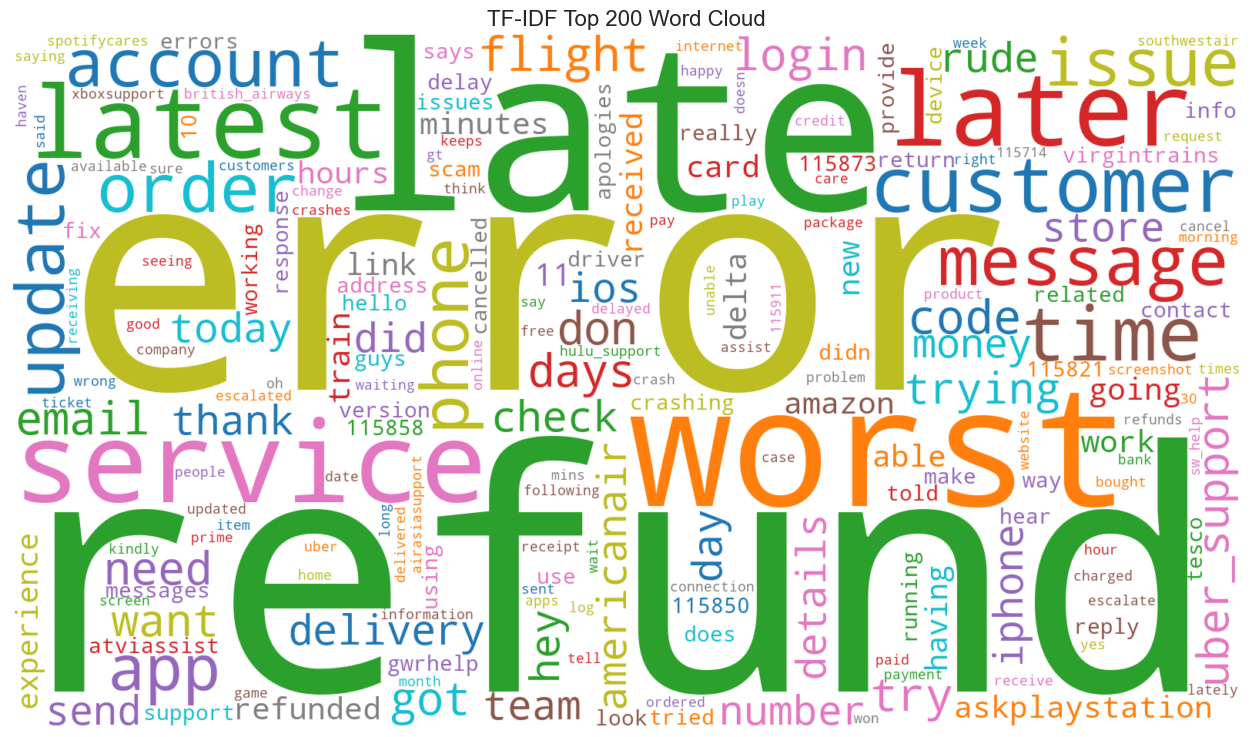

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

top_n=200

# 清洗数据
corpus_clean = [str(doc) for doc in df_text['text'] if pd.notna(doc)]

# 计算TF-IDF
vectorizer = TfidfVectorizer(stop_words=combined_stopwords)
tfidf_matrix = vectorizer.fit_transform(corpus_clean)
feature_names = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1

# 提取词和对应得分
tfidf_scores = dict(zip(feature_names, scores))
tfidf_top = dict(sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)[:top_n])

wordcloud = WordCloud(
    width=1600,
    height=900,
    background_color='white',
    colormap='tab10'
).generate_from_frequencies(tfidf_top)

plt.figure(figsize=(16, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title(f"TF-IDF Top {top_n} Word Cloud", fontsize=16)
# plt.savefig(f'{PLOT}tfidf_wordcloud.png')
plt.show()
plt.close()